In [ ]:
# Importings...
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import torch

In [ ]:
# set random seed for reproducibility
import random  
import os
def set_all_seeds(seed=1):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

set_all_seeds(1)

In [3]:
# Load data
stock_df = pd.read_csv('Google_Stock_Price.csv')
stock_df.head(10)

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"
5,1/10/2012,313.70,315.72,307.30,621.43,"8,824,000"
6,1/11/2012,310.59,313.52,309.40,624.25,"4,817,800"
7,1/12/2012,314.43,315.26,312.08,627.92,"3,764,400"
8,1/13/2012,311.96,312.30,309.37,623.28,"4,631,800"
9,1/17/2012,314.81,314.81,311.67,626.86,"3,832,800"


In [4]:
# Describe the data
stock_df.describe()

,Open,High,Low
count,1278.000000,1278.000000,1278.000000
mean,537.994906,542.168897,533.278803
std,154.508365,155.582501,153.174011
min,279.120000,281.210000,277.220000
25%,406.037500,408.230000,403.335000
50%,538.395000,542.330000,534.355000
75%,668.862500,677.705000,662.190000
max,837.810000,841.950000,827.010000


In [5]:
# Check the data
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1278 entries, 0 to 1277
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1278 non-null   object 
 1   Open    1278 non-null   float64
 2   High    1278 non-null   float64
 3   Low     1278 non-null   float64
 4   Close   1278 non-null   object 
 5   Volume  1278 non-null   object 
dtypes: float64(3), object(3)
memory usage: 60.0+ KB


In [6]:
# Drop unecessary data
stock_df.drop('Date', axis=1, inplace=True)

In [7]:
# Remove commas and change dtypes
stock_df.replace(regex=True,inplace=True,to_replace=r'\D',value=r'')

stock_df.astype('float64')

,Open,High,Low,Close,Volume
0,325.25,332.83,324.97,66359.0,7380500.0
1,331.27,333.87,329.08,66645.0,5749400.0
2,329.83,330.75,326.89,65721.0,6590300.0
3,328.34,328.77,323.68,64824.0,5405900.0
4,322.04,322.29,309.46,62076.0,11688800.0
...,...,...,...,...,...
1273,829.62,835.77,825.06,83567.0,1494500.0
1274,837.81,838.00,827.01,83215.0,2973900.0
1275,834.71,841.95,820.44,82331.0,2965800.0
1276,814.66,815.84,799.80,80232.0,3246600.0


In [8]:
# Split training and validation sets
stock_df_train = stock_df[:int(0.6*len(stock_df))]
stock_df_valid = stock_df[int(0.6*len(stock_df)):int(0.8*len(stock_df))]
stock_df_test = stock_df[int(0.8*len(stock_df)):]

In [9]:
# Normalization
scaler = MinMaxScaler()
scaler = scaler.fit(stock_df_train)
stock_df_train = scaler.transform(stock_df_train)
stock_df_valid = scaler.transform(stock_df_valid)
stock_df_test =  scaler.transform(stock_df_test)

In [10]:
# Split X and y
def split_x_and_y(array, days_used_to_train=7):
    features = list()
    labels = list()

    for i in range(days_used_to_train, len(array)):
        features.append(array[i-days_used_to_train:i, :])
        labels.append(array[i, -1])
    return np.array(features), np.array(labels)

train_X, train_y = split_x_and_y(stock_df_train)
valid_X, valid_y = split_x_and_y(stock_df_valid)
test_X, test_y = split_x_and_y(stock_df_test)

print('Shape of Train X: {} \n Shape of Train y: {}'.format(train_X.shape, train_y.shape))
print(train_X[:5, -1, -1])
print(train_y[:5])

Shape of Train X: (759, 7, 5) 
 Shape of Train y: (759,)
[0.19262715 0.15044053 0.18517821 0.15317982 0.22171005]
[0.15044053 0.18517821 0.15317982 0.22171005 0.50660392]


In [11]:
# convert to pyTorch tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_X_tensor = torch.FloatTensor(train_X).to(device)
train_y_tensor = torch.FloatTensor(train_y).to(device)
valid_X_tensor = torch.FloatTensor(valid_X).to(device)
valid_y_tensor = torch.FloatTensor(valid_y).to(device)
test_X_tensor = torch.FloatTensor(test_X).to(device)
test_y_tensor = torch.FloatTensor(test_y).to(device)

In [ ]:
# create DataLoaders for training and validation sets
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(train_X_tensor, train_y_tensor)
valid_dataset = TensorDataset(valid_X_tensor, valid_y_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [13]:
# define the LSTM model
import torch.nn as nn
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dense = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # LSTM output: (batch_size, seq_len, hidden_size)
        lstm_out, (hidden, cell) = self.lstm(x)
        # only take the output of the last time step
        output = self.dense(lstm_out[:, -1, :])  # (batch_size, output_size)
        return output

input_size = train_X.shape[2]
model = LSTMModel(input_size=input_size, hidden_size=64, output_size=1).to(device)

In [ ]:
# define the optimizer and loss function
import torch.optim as optim
optimizer = optim.Adam(model.parameters())
criterion = nn.MSELoss()

In [ ]:
# train the model
epochs = 100
train_losses = []
valid_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs.squeeze(), batch_y)
        
        batch_size = batch_x.size(0)
        train_loss += loss.item() * batch_size  
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    model.eval()
    valid_loss = 0.0
    
    with torch.no_grad():
        for batch_x, batch_y in valid_loader:
            outputs = model(batch_x)
            loss = criterion(outputs.squeeze(), batch_y)
            
            batch_size = batch_x.size(0)
            valid_loss += loss.item() * batch_size
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_valid_loss = valid_loss / len(valid_loader.dataset)
    
    train_losses.append(avg_train_loss)
    valid_losses.append(avg_valid_loss)
    
    print(f'Epoch {epoch+1}/{epochs} | '
          f'Train Loss: {avg_train_loss:.6f} | '
          f'Valid Loss: {avg_valid_loss:.6f}')

Epoch 1/100 | Train Loss: 0.011146 | Valid Loss: 0.002925
Epoch 2/100 | Train Loss: 0.007603 | Valid Loss: 0.003002
Epoch 3/100 | Train Loss: 0.007225 | Valid Loss: 0.004919
Epoch 4/100 | Train Loss: 0.007232 | Valid Loss: 0.003641
Epoch 5/100 | Train Loss: 0.007053 | Valid Loss: 0.004280
Epoch 6/100 | Train Loss: 0.006940 | Valid Loss: 0.003541
Epoch 7/100 | Train Loss: 0.006927 | Valid Loss: 0.003303
Epoch 8/100 | Train Loss: 0.006820 | Valid Loss: 0.006291
Epoch 9/100 | Train Loss: 0.006819 | Valid Loss: 0.003976
Epoch 10/100 | Train Loss: 0.006610 | Valid Loss: 0.003025
Epoch 11/100 | Train Loss: 0.006517 | Valid Loss: 0.003342
Epoch 12/100 | Train Loss: 0.006433 | Valid Loss: 0.003943
Epoch 13/100 | Train Loss: 0.006319 | Valid Loss: 0.003951
Epoch 14/100 | Train Loss: 0.006318 | Valid Loss: 0.003592
Epoch 15/100 | Train Loss: 0.006150 | Valid Loss: 0.003108
Epoch 16/100 | Train Loss: 0.006043 | Valid Loss: 0.003164
Epoch 17/100 | Train Loss: 0.005990 | Valid Loss: 0.002262
Epoch 

In [ ]:
# evaluate the model on the test set
model.eval()
with torch.no_grad():
    pred_y = model(test_X_tensor).cpu().numpy().squeeze()

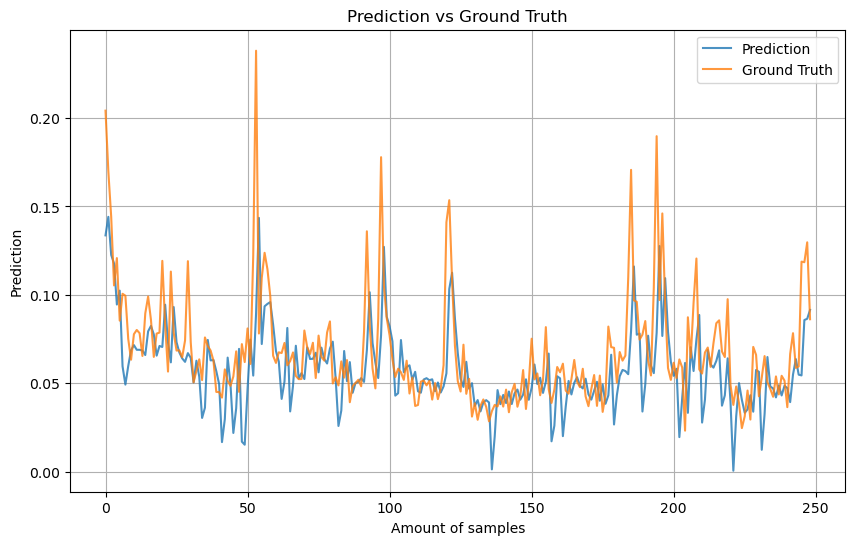

In [ ]:
# plotting the predictions against the ground truth
test_y_np = test_y_tensor.cpu().numpy()

plt.figure(figsize=(10, 6))
plt.plot(range(len(pred_y)), pred_y, label='Prediction', alpha=0.8)
plt.plot(range(len(test_y_np)), test_y_np, label='Ground Truth', alpha=0.8)
plt.xlabel('Amount of samples')
plt.ylabel('Prediction')
plt.title('Prediction vs Ground Truth')
plt.legend()
plt.grid(True)
plt.show()